In [1]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import pymc as pm

In [2]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.0.1


In [3]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [4]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

Text(0.5, 0, 'X2')

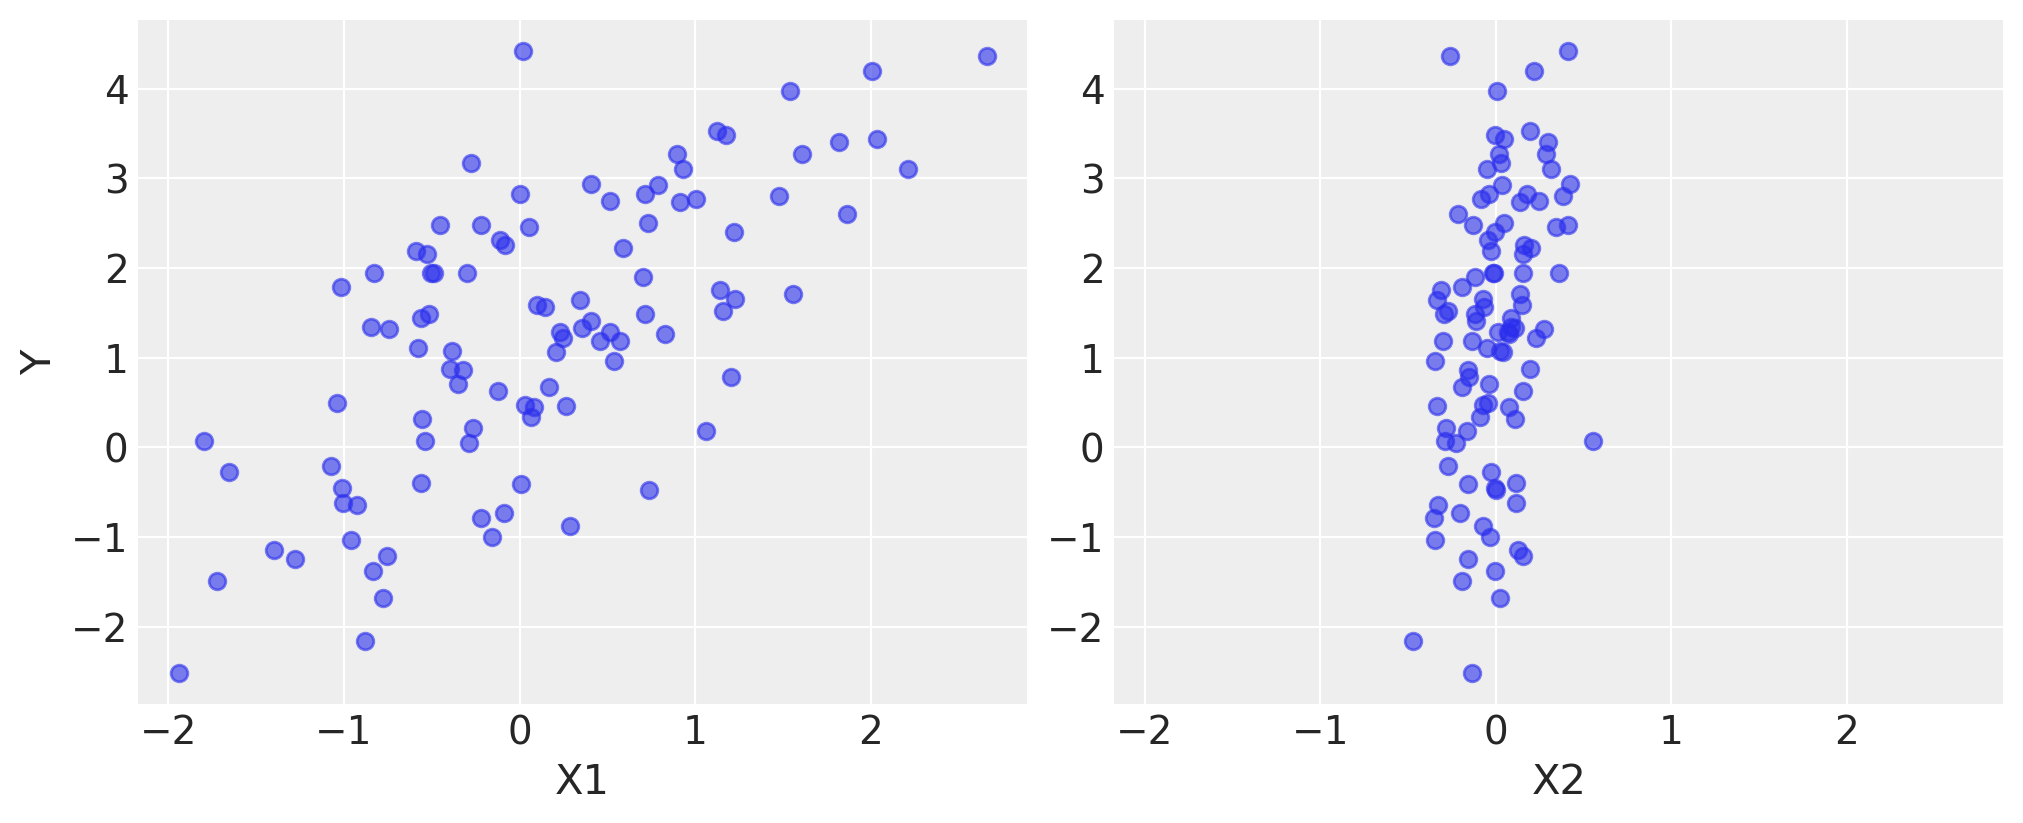

In [5]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2")

In [6]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [7]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [8]:
idata.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)>
array([[1.30725611, 0.99636603, 0.99523251, 1.32177315, 1.35296035],
       [1.23518407, 0.96498136, 0.95134032, 1.35686801, 0.83365359],
       [1.2355826 , 1.22878414, 1.16848533, 0.88845363, 1.40419601],
       [1.18476508, 1.18476508, 1.24342667, 1.01893218, 1.26892322]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4

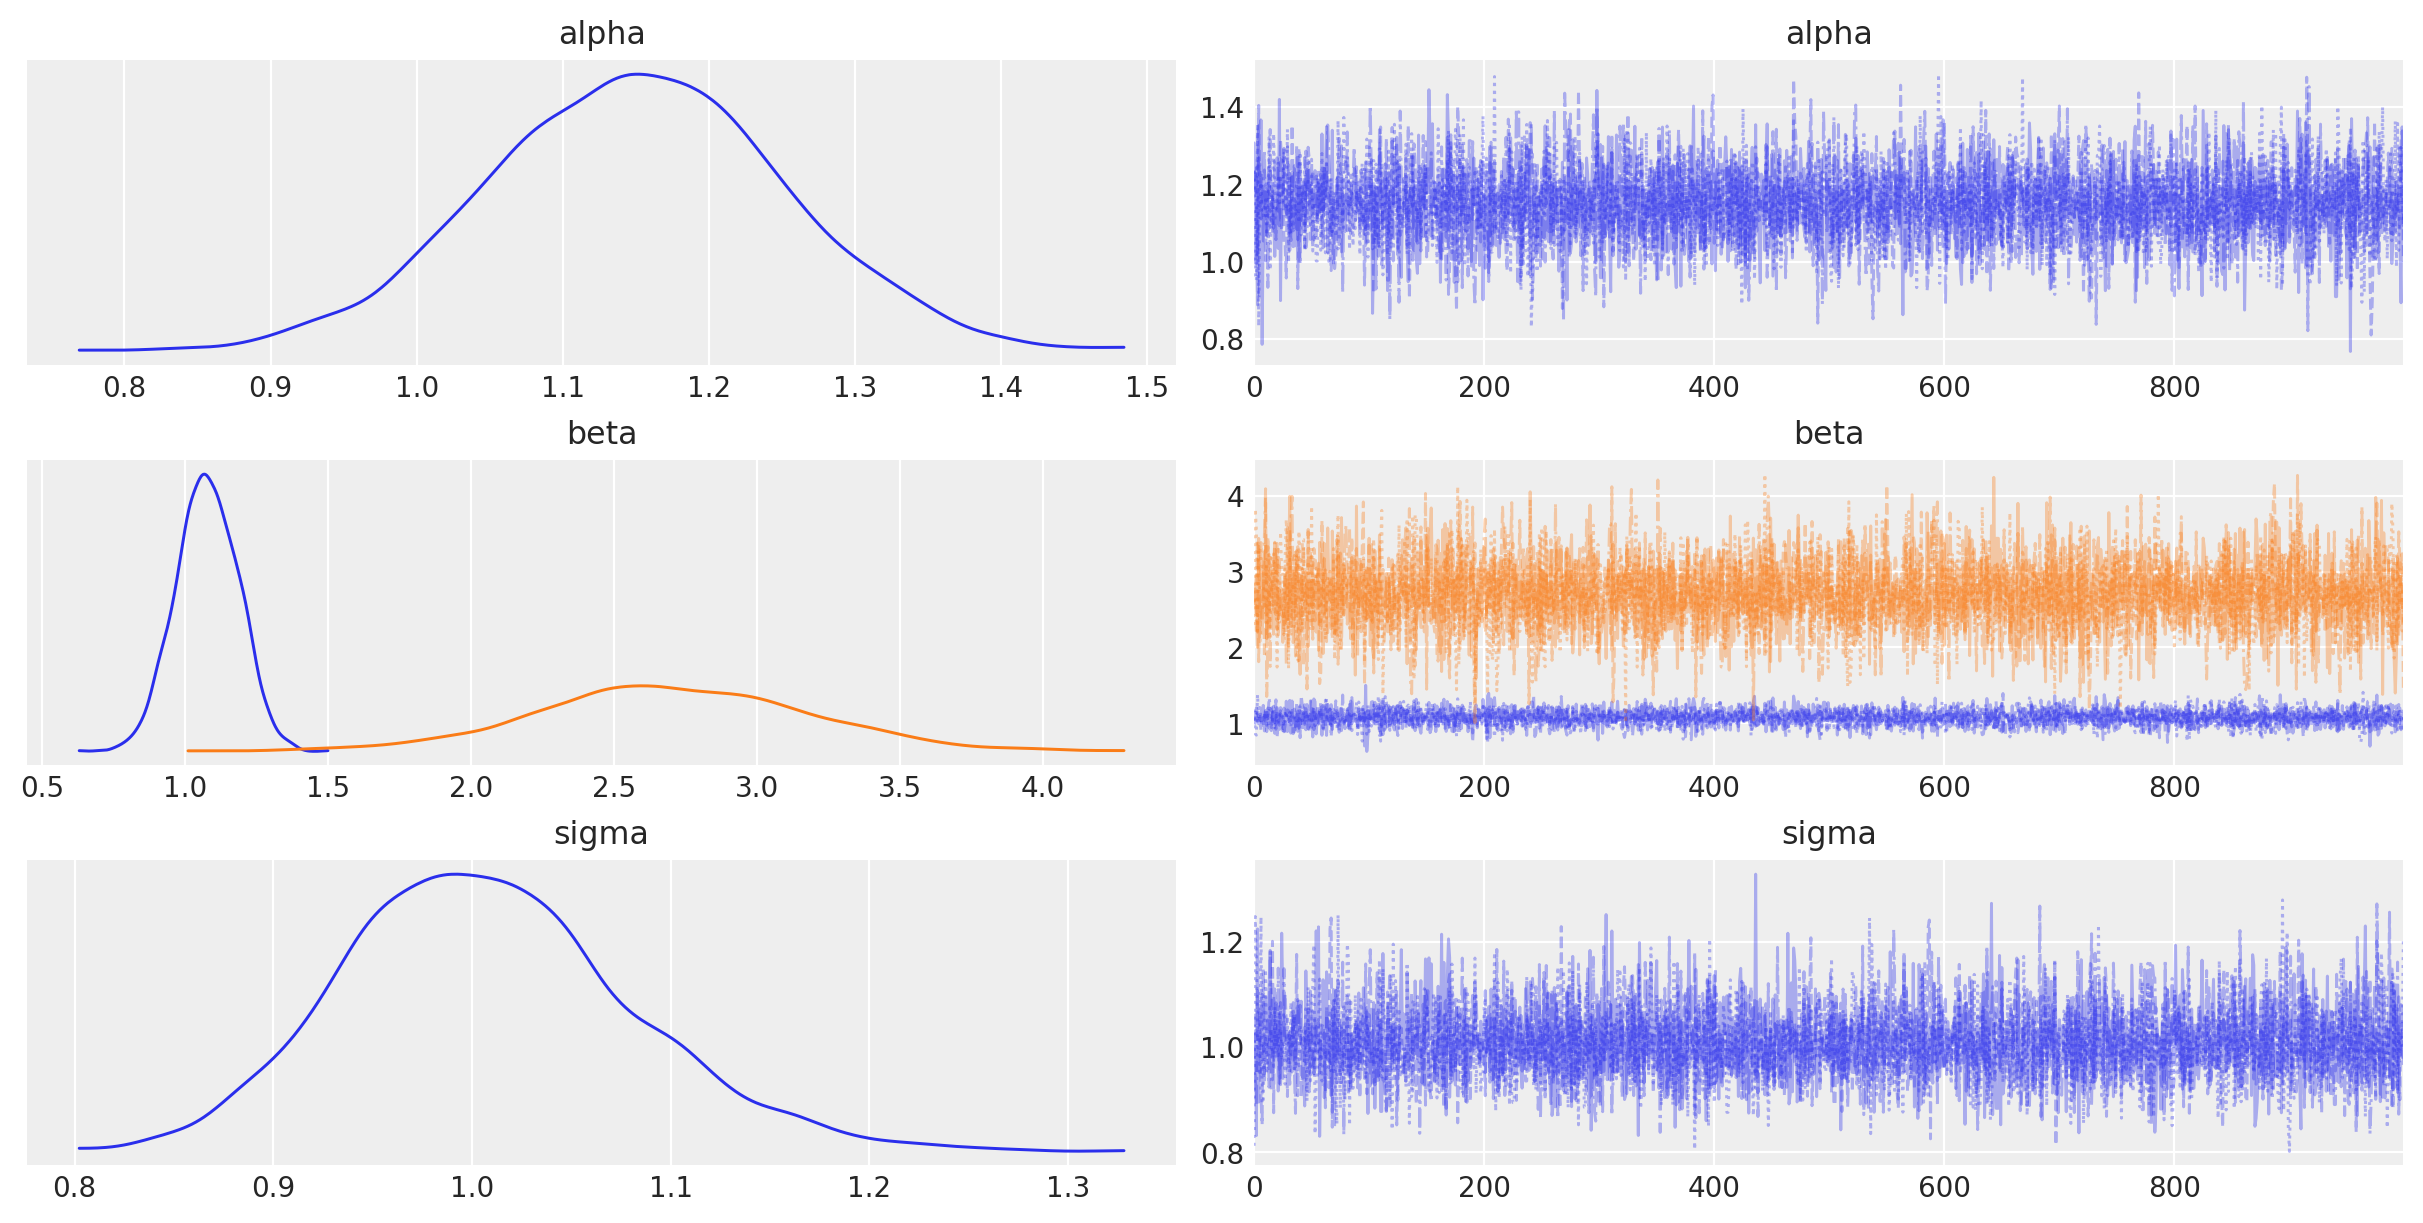

In [9]:
az.plot_trace(idata, combined=True);

In [10]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.15,0.10,0.98,1.36,0.00,0.0,6408.12,3569.00,1.0
beta[0],1.08,0.11,0.89,1.29,0.00,0.0,6053.11,2959.96,1.0
beta[1],2.70,0.48,1.83,3.62,0.01,0.0,5627.03,3301.32,1.0
sigma,1.01,0.07,0.87,1.15,0.00,0.0,6738.79,3264.90,1.0


# Data

In [11]:
df = pd.read_pickle('fulldataframe.pkl')
df

,date,LosAngelesCA,NewYorkNY,RaleighNC,OklahomaCityOK,SaltLakeCityUT,MORTGAGE30US,MedianCPI,HomesForSale,HomesSold,LosAngelesUnemployment,NewYorkUnemployment,RaleighUnemployment,SaltLakeCityUnemployment,OklahomaCityUnemployment
0,2000-01-31,240598.0,226266.0,176753.0,91918.0,190020.0,8.25,2.785584,82.0,67.0,5.1,5.1,2.5,3.1,2.9
1,2000-02-29,241457.0,227618.0,176909.0,92156.0,190141.0,8.31,3.416809,79.0,78.0,5.1,5.0,2.6,3.4,3.0
2,2000-03-31,242727.0,228829.0,177351.0,92378.0,190386.0,8.23,2.276901,86.0,88.0,5.1,4.8,2.4,3.3,2.8
3,2000-04-30,245142.0,231213.0,178077.0,92742.0,190866.0,8.13,2.853534,80.0,78.0,5.1,4.1,2.0,2.9,2.2
4,2000-05-31,247707.0,233418.0,179033.0,93124.0,193543.0,8.62,3.142535,84.0,77.0,5.1,4.3,2.5,3.0,2.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,2022-07-31,988839.0,620305.0,462448.0,220174.0,625456.0,5.30,9.222973,43.0,44.0,4.3,4.7,3.1,2.1,2.9
271,2022-08-31,973842.0,622586.0,459364.0,221448.0,611770.0,5.55,8.307776,46.0,51.0,4.1,4.9,3.3,2.1,3.1
272,2022-09-30,963691.0,623535.0,454956.0,222529.0,606227.0,6.70,6.532852,55.0,45.0,4.1,3.7,2.8,1.9,3.1
273,2022-10-31,953568.0,623959.0,452496.0,223638.0,602751.0,7.08,5.609658,59.0,45.0,4.0,3.7,3.3,2.1,3.3


In [12]:
standard_features = ['date', 'MORTGAGE30US', 'MedianCPI', 'HomesForSale', 'HomesSold']

la_df = df[standard_features + ['LosAngelesCA', 'LosAngelesUnemployment']]
la_df.set_index('date', inplace=True)
la_df

,MORTGAGE30US,MedianCPI,HomesForSale,HomesSold,LosAngelesCA,LosAngelesUnemployment
date,,,,,,
2000-01-31,8.25,2.785584,82.0,67.0,240598.0,5.1
2000-02-29,8.31,3.416809,79.0,78.0,241457.0,5.1
2000-03-31,8.23,2.276901,86.0,88.0,242727.0,5.1
2000-04-30,8.13,2.853534,80.0,78.0,245142.0,5.1
2000-05-31,8.62,3.142535,84.0,77.0,247707.0,5.1
...,...,...,...,...,...,...
2022-07-31,5.30,9.222973,43.0,44.0,988839.0,4.3
2022-08-31,5.55,8.307776,46.0,51.0,973842.0,4.1
2022-09-30,6.70,6.532852,55.0,45.0,963691.0,4.1


In [13]:
sample_df = la_df[['LosAngelesCA', 'LosAngelesUnemployment']]
sample_df

,LosAngelesCA,LosAngelesUnemployment
date,,
2000-01-31,240598.0,5.1
2000-02-29,241457.0,5.1
2000-03-31,242727.0,5.1
2000-04-30,245142.0,5.1
2000-05-31,247707.0,5.1
...,...,...
2022-07-31,988839.0,4.3
2022-08-31,973842.0,4.1
2022-09-30,963691.0,4.1


# Frequentist VAR

In [14]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [15]:
data = pd.concat([sample_df['LosAngelesCA'].diff().dropna(), 
                  sample_df.drop(['LosAngelesCA'], axis=1).iloc[1:,:]], axis=1)
data.head(10)

,LosAngelesCA,LosAngelesUnemployment
date,,
2000-02-29,859.0,5.1
2000-03-31,1270.0,5.1
2000-04-30,2415.0,5.1
2000-05-31,2565.0,5.1
2000-06-30,2432.0,5.0
2000-07-31,2497.0,5.0
2000-08-31,2615.0,4.9
2000-09-30,2486.0,4.8
2000-10-31,2272.0,4.8


In [16]:
model = VAR(data)

/opt/homebrew/Caskroom/miniforge/base/envs/bayes/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [17]:
results=model.fit(2)

In [18]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 26, Jan, 2023
Time:                     20:44:11
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.6921
Nobs:                     272.000    HQIC:                   14.6127
Log likelihood:          -2741.99    FPE:                2.10434e+06
AIC:                      14.5595    Det(Omega_mle):     2.02905e+06
--------------------------------------------------------------------
Results for equation LosAngelesCA
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                          -196.819089       348.305472           -0.565           0.572
L1.LosAngelesCA                   1.169769         0.058097           20.135           0.000
L1.Lo

# Bayesian VAR
Sources:  
https://www.pymc.io/projects/examples/en/latest/time_series/bayesian_var_model.html  
https://www.pymc-labs.io/blog-posts/bayesian-vector-autoregression/

In [20]:
# code adapted from https://www.pymc-labs.io/blog-posts/bayesian-vector-autoregression/ 
lags = 2

coords={
    "lags": reversed(range(-lags, 0)),
    "vars": list(data.columns),
    "cross_vars": list(data.columns),
    "time": range(len(data) - lags),
}

with pm.Model(coords=coords) as BVAR_model:
    # Define priors for interecepts, lag coefficients, and noise
    intercept = pm.Normal("intercept", mu=0, sigma=1, dims=("vars",))
    lag_coefs = pm.Normal("lag_coefs", mu=0, sigma=1, dims=("lags", "vars", "cross_vars"))
    noise = pm.HalfNormal("noise", dims=("vars",))

    # Compute autoregression expectations for each column
    ar_terms = []
    
    for j in range(len(data.columns)):
        # convolve each variable's matrix of lag coefficients over the dataframe
        ar = pm.math.sum([
            pm.math.sum(lag_coefs[i, j] * data.values[lags-(i+1): -(i+1)], axis=1)
            for i in range(lags)
        ], axis=0)
        ar_terms.append(ar)
    
     
    # Add intercept terms to our autoregression expectations
    mean = intercept + pm.math.stack([ar for ar in ar_terms], axis=-1)

    # Define our observed stochastic variable. Restrict to observations that have lags available.
    obs = pm.Normal("obs", mu=mean, sigma=noise, observed=data[lags:], dims=("time", "vars"))


In [21]:
with BVAR_model:
    trace = pm.sample(chains=4, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, lag_coefs, noise]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


array([[<AxesSubplot: title={'center': 'intercept'}>,
        <AxesSubplot: title={'center': 'intercept'}>],
       [<AxesSubplot: title={'center': 'lag_coefs'}>,
        <AxesSubplot: title={'center': 'lag_coefs'}>],
       [<AxesSubplot: title={'center': 'noise'}>,
        <AxesSubplot: title={'center': 'noise'}>]], dtype=object)

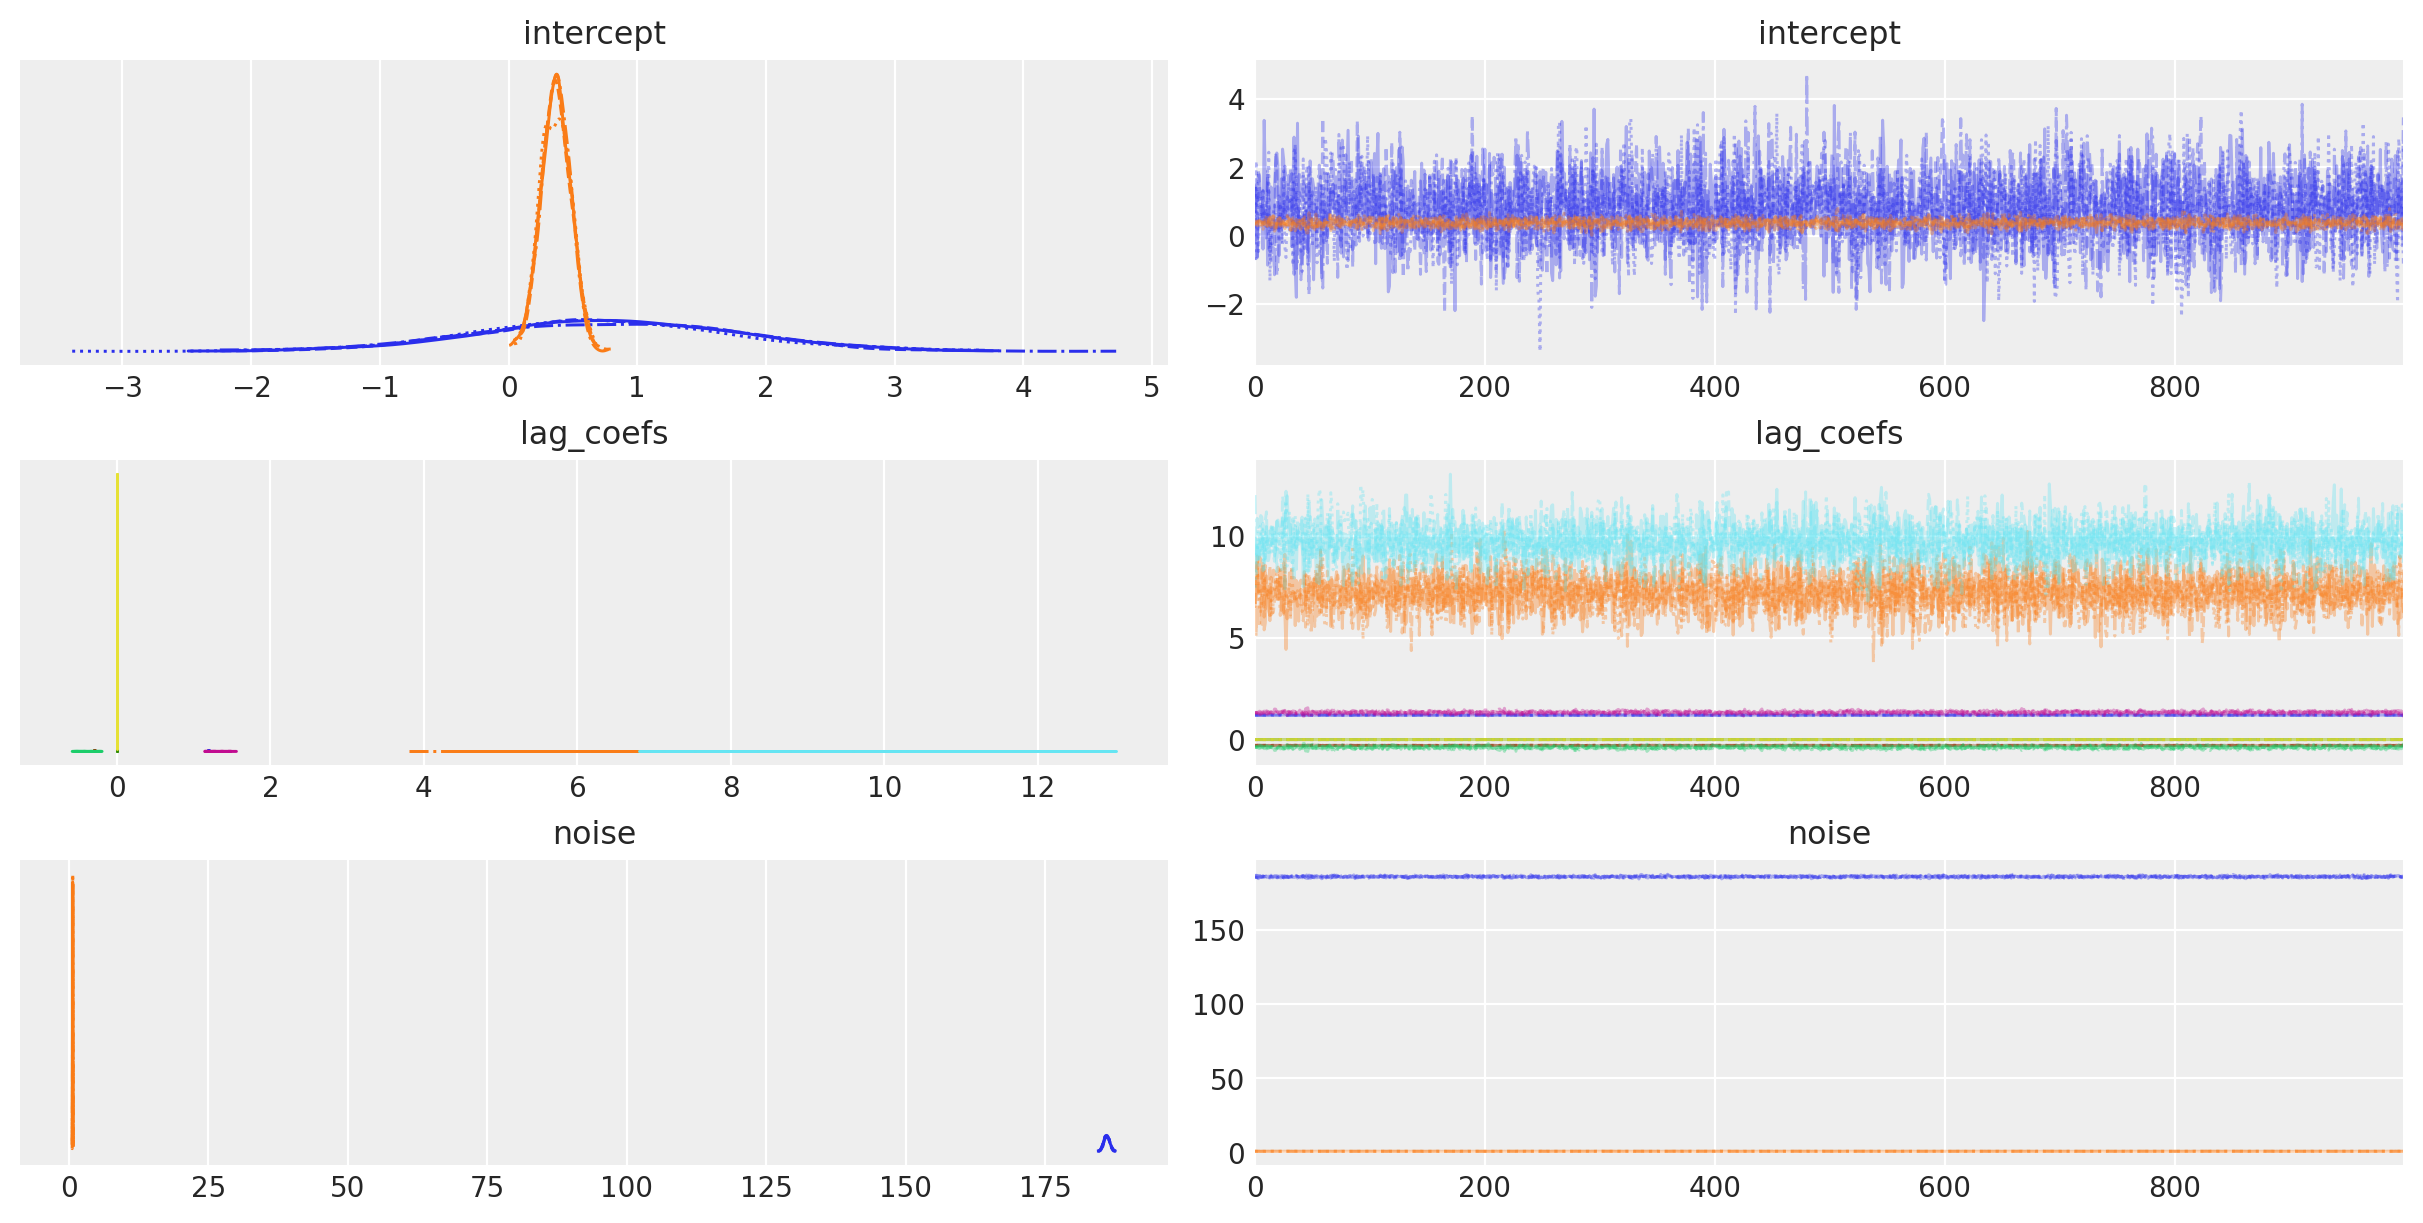

In [22]:
az.plot_trace(trace)

In [23]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept[LosAngelesCA],0.768,1.007,-1.150,2.672,0.015,0.013,4347.0,3270.0,1.0
intercept[LosAngelesUnemployment],0.367,0.112,0.151,0.566,0.002,0.001,4241.0,3129.0,1.0
"lag_coefs[-1, LosAngelesCA, LosAngelesCA]",1.199,0.005,1.189,1.209,0.000,0.000,2427.0,2532.0,1.0
"lag_coefs[-1, LosAngelesCA, LosAngelesUnemployment]",7.237,0.895,5.525,8.863,0.014,0.010,4012.0,3040.0,1.0
"lag_coefs[-1, LosAngelesUnemployment, LosAngelesCA]",0.000,0.000,-0.000,0.000,0.000,0.000,2578.0,2504.0,1.0
"lag_coefs[-1, LosAngelesUnemployment, LosAngelesUnemployment]",1.330,0.057,1.222,1.435,0.001,0.001,2397.0,2675.0,1.0
"lag_coefs[-2, LosAngelesCA, LosAngelesCA]",-0.287,0.005,-0.297,-0.277,0.000,0.000,2483.0,2457.0,1.0
"lag_coefs[-2, LosAngelesCA, LosAngelesUnemployment]",9.690,0.898,8.028,11.445,0.014,0.010,4050.0,3272.0,1.0
"lag_coefs[-2, LosAngelesUnemployment, LosAngelesCA]",-0.000,0.000,-0.000,0.000,0.000,0.000,2624.0,2619.0,1.0
"lag_coefs[-2, LosAngelesUnemployment, LosAngelesUnemployment]",-0.379,0.057,-0.487,-0.274,0.001,0.001,2419.0,2741.0,1.0
